# Preprocessing and modeling
We are now set to do some actual modeling to predict churn. 

Recall that so far we have cleaned the data, explored the data through several means including visualizations, and we have successfully generated several numerical columns to help with our predictions. Now we would conduct some more preprocessing including splitting our dataset into train and test sets, dummifying categorical features, and scaling.

After that we would build some models. Let's begin with some imports.

In [1]:
#Importing our libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.ensemble import (RandomForestClassifier, StackingClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, BaggingClassifier, StackingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (balanced_accuracy_score, ConfusionMatrixDisplay, 
                            recall_score, precision_score, fbeta_score)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from imblearn.metrics import geometric_mean_score

import pickle

In [2]:
#Reading in our dataset
brass_v2 = pd.read_csv('../data/brass_v2.csv')

#Checking
brass_v2.head()

,id,registration_type,industry,is_high_value,avg_ledger_bal,cred_count_ratio,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio,coeff_var,churn
0,21,Enterprise,General Services,0,5.000000e+01,0.005917,0.005917,1.000000e+02,100.000000,0.591716,0.591716,0.000000,0
1,122,Limited Liability,Technology,0,1.000000e+04,0.003831,0.003831,2.000000e+04,12000.000000,76.628352,45.977011,1.414214,1
2,159,Sole Proprietorship,Technology,1,2.122603e+06,0.037344,0.265560,2.549667e+06,357016.828281,10579.529737,1481.397628,1.229588,0
3,217,Limited Liability,Digital Services,0,6.500000e+03,0.004545,0.004545,1.300000e+04,12000.000000,59.090909,54.545455,1.414214,1
4,323,Sole Proprietorship,Others,0,1.974115e+04,0.084337,0.309237,1.131905e+04,3036.036494,45.458023,12.192918,0.815543,0


Our dataframe has 12 columns. However, not all the columns would be used for modeling. 
The `id` column - for instance - consists of unique identifiers that would add nothing to our model. 

My plan is to use only the 9 numerical features for a start. Depending on the performance of my model, I would then decide on using categorical features. 

# Splitting dataset into train and test sets

In [3]:
#feature matrix
X = brass_v2.drop(columns = ['id', 'churn', 'industry', 'registration_type'])  #also dropping churn for the feature matrix because it is the target

#Target
y = brass_v2['churn']

In [4]:
#checking - looks as expected
X.head(2)

,is_high_value,avg_ledger_bal,cred_count_ratio,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio,coeff_var
0,0,50.0,0.005917,0.005917,100.0,100.0,0.591716,0.591716,0.000000
1,0,10000.0,0.003831,0.003831,20000.0,12000.0,76.628352,45.977011,1.414214


In [5]:
#Splitting into train and test sets with a train size of 0.7 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#Checking the shapes - looks good
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1045, 9), (448, 9), (1045,), (448,))

In [6]:
# Creating dummy variables variables representing the registration_type in the train and test datasets

X_train_dum = pd.get_dummies(data = X_train, columns = ['registration_type'], drop_first=True)
X_test_dum = pd.get_dummies(data = X_test, columns = ['registration_type'], drop_first=True) 

KeyError: "None of [Index(['registration_type'], dtype='object')] are in the [columns]"

To avoid misalignment between the train and test data, I'll use the `.align` command to make sure they are both encoded and ordered in the same way.

For the `join` parameter, I will specify a left join so that the train dataset - on the left - is the reference and if there's any mismatch between the two datasets, `.align` ensures it keeps everything contained in train. 

The `fill_value` parameter ensures that if there is any NaN value because of a feature in the train that is not in the test, it gets filled with what I have specified, which in this case is 0.

In [ ]:
X_train, X_test = X_train_dum.align(X_test_dum, join='left', axis=1, fill_value=0)

In [ ]:
X_train.head(2)

In [7]:
X_test.head(2)

,is_high_value,avg_ledger_bal,cred_count_ratio,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio,coeff_var
1348,0,1519.968750,0.035294,0.058824,3006.666667,1195.300,35.372549,14.062353,0.709752
298,0,3867.064118,0.028000,0.040000,4428.571429,3095.738,17.714286,12.382952,1.312469


# Scaling

In [8]:
# Instantiate StandardScaler
ss = StandardScaler()

In [9]:
Z_train = ss.fit_transform(X_train)

Z_test = ss.transform(X_test)

In [10]:
#I'll like the transformed data to be in a dataframe - not compulsory though

Z_train = pd.DataFrame(Z_train, columns=X_train.columns, index=X_train.index)

Z_test = pd.DataFrame(Z_test, columns=X_test.columns, index=X_test.index)

In [11]:
#Checking - it is now scaled and in a dataframe
Z_test.head(2)

,is_high_value,avg_ledger_bal,cred_count_ratio,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio,coeff_var
1348,-0.381881,-0.092138,-0.097397,-0.088355,-0.149827,-0.158730,-0.100001,-0.049964,-0.209331
298,-0.381881,-0.091824,-0.099916,-0.090592,-0.148760,-0.151744,-0.100921,-0.050074,0.207962


# Modeling

Below I want to define functions that would help me in instantiating, fitting, and then evaluating my models on some key metrics. 

The function `modeling` would take in eight inputs. Then it would output a dataframe containing five evaluation metrics each for the train and test data; as well as a confusion matrix. 

As I noted in the [first notebook](http://localhost:8917/files/notebooks/01_introduction.ipynb?_xsrf=2%7Cffdccb23%7Cfb417d47244e6deb916a908cfc4c5566%7C1675721470), the five evaluation metrics to be outputed are:
- **Accuracy score** 
- **Balanced accuracy score**
- **Recall/Sensitivity**
- **Geometric mean**
- **Fbeta score** 

In [12]:
def modeling(alg, alg_name, X_train, X_test, y_train, y_test, results_dict, params={}):
    '''
    This function takes in the following inputs:
    - alg = The model to be instantiated
    - alg_name = The name you'll like the model to be called in your output
    - X_train = a pandas dataframe containing the training data with your predictor features
    - X_test = a pandas dataframe containing the testing data with your predictor features
    - y_train = a pandas series containing your target feature in the train dataset
    - y_test = a pandas series containing your target feature in the test dataset
    - results_dict = a dictionary containing the ten evaluation metrics (five each for train and test sets) 
    from all previously evaluated models, plus the ten evaluation metrics from the current model. 
    - params = this input is optional but if present, it'll contain hyperparameters to be used while instantiating the model
    
    This function outputs the following:
    - results_df = a dataframe containing the items in the results_dict. 
    - A confusion matrix for the particular model being considered. 
    
    '''
    #First the modeling
    model = alg(**params) #Instantiating model. 
    model.fit(X_train, y_train) #Fitting model
    preds_train = model.predict(X_train) #making prediction on train data just for the sake of comparison
    preds = model.predict(X_test) #making predictions on test data
    
    #then the evaluation
    results_dict[alg_name] = {
    'train_accuracy' : model.score(X_train, y_train),
    'test_accuracy' : model.score(X_test, y_test), 
    'train_bal_accuracy' : balanced_accuracy_score(y_train, preds_train),
    'test_bal_accuracy' : balanced_accuracy_score(y_test, preds),
    'train_recall' : recall_score(y_train, preds_train),
    'test_recall' : recall_score(y_test, preds),
    'train_geom_mean' : geometric_mean_score(y_train, preds_train, average='weighted'),
    'test_geom_mean' : geometric_mean_score(y_test, preds, average='weighted'),
    'train_fbeta': fbeta_score(y_train, preds_train, average='weighted', beta=1.5),
    'test_fbeta': fbeta_score(y_test, preds, average='weighted', beta=1.5)
                }
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Not Churn', 'Churn'])
    
    #Then the results
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')

    
    return results_df

# Logistic regression (LR) model

Recall that our `modeling` function above contains a parameter called `results_dict`. That parameter would hold the evaluation metrics for our different models. That means after evaluating a model, its metrics would be tacked onto it, and then when we move to the next model, its own metrics would be tacked onto the same dictionary, and so on. In the end we would have a dictionary containing all the different metrics for all our models. The contents of the dictionary would be displayed in the results_df dataframe. 

So right now, we would start off by instantiating that empty dictionary - `results_dict`.

In [13]:
#Instantiating an empty dictionary to contain our evaluation metrics
results_dict = {}

,train_accuracy,test_accuracy,train_bal_accuracy,test_bal_accuracy,train_recall,test_recall,train_geom_mean,test_geom_mean,train_fbeta,test_fbeta
Logistic Regression,0.802871,0.796875,0.535152,0.515957,0.072727,0.031915,0.463372,0.432779,0.753723,0.741797


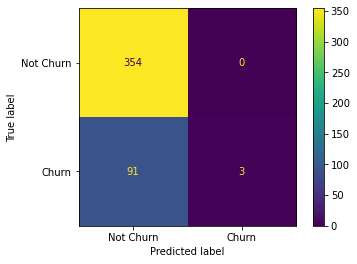

In [14]:
#Instantiating, fitting and evaluating a Logistic Regression model with random seed = 42

modeling(LogisticRegression, 'Logistic Regression', Z_train, Z_test, y_train, y_test, results_dict, params = {'random_state': 42})

## What does this result mean? LR edition:

This is a really bad result no matter how you look at it. 
Recall that our null accuracy was 79% - which is the proportion of our majority class (not churn). At 79.7%, this model's accuracy is basically equal to the null accuracy. We can say it is just like guessing. As mentioned previously, `accuracy` is not a good measure to evaluate this problem due to the imbalaned nature of the classes. When this model is evaluated on `balanced accuracy` which measures the average accuracy obtained from the majority and minority classes, it drops precipitiously to 51.6%, and the recall score which we are very interested in for this problem, is a measly 3.2%. 

In the confusion matrix, we are most interested in the third quadrant. We need the values in that quadrant to be as low as possible. Unfortunately, for this model, it is very high. Out of the 94 customers in the test data who have churned, our model incorrectly classified 91 of them as 'not churn'. It predicted churn correctly only three times. 

We have to try other models now and hope to see some improvements otherwise we may have to go back to the features we engineered. 

# Random Forest (RF) model

,train_accuracy,test_accuracy,train_bal_accuracy,test_bal_accuracy,train_recall,test_recall,train_geom_mean,test_geom_mean,train_fbeta,test_fbeta
Logistic Regression,0.802871,0.796875,0.535152,0.515957,0.072727,0.031915,0.463372,0.432779,0.753723,0.741797
Random Forest,1.000000,0.924107,1.000000,0.838683,1.000000,0.691489,1.000000,0.834321,1.000000,0.920558


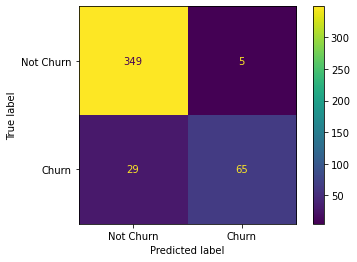

In [15]:
#Instantiating, fitting and evaluating a Random Forest model with random seed = 42

modeling(RandomForestClassifier, 'Random Forest', Z_train, Z_test, y_train, y_test, results_dict, params = {'random_state': 42})

## What does this result mean? RF Edition:

We wanted a much improved model and we got it here with this Random Forest model. Its accuracy is over 92%, its balanced accuracy is 83.4% (compared to 51.5% in the LR model). its recall is about 69% (compared to 3% in the LR model). And it had very solid geometric mean and fbeta acores as well. It is overfit though, but we would come to that at another time. 

In its confusion matrix, we can see in the third quadrant that it is incorrectly predicting 29 churned customers as not churn, but it correctly classifies 65 churned customers - a marked improvement from the LR model which only correctly classified 3 churned customers. 

# Decision Tree Classifier (DT) model

,train_accuracy,test_accuracy,train_bal_accuracy,test_bal_accuracy,train_recall,test_recall,train_geom_mean,test_geom_mean,train_fbeta,test_fbeta
Logistic Regression,0.802871,0.796875,0.535152,0.515957,0.072727,0.031915,0.463372,0.432779,0.753723,0.741797
Random Forest,1.000000,0.924107,1.000000,0.838683,1.000000,0.691489,1.000000,0.834321,1.000000,0.920558
Decision Tree,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144


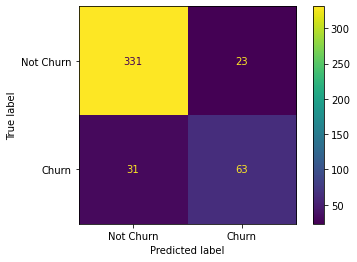

In [16]:
#Instantiating, fitting and evaluating a Decision Tree model with random seed = 42

modeling(DecisionTreeClassifier, 'Decision Tree', Z_train, Z_test, y_train, y_test, results_dict, params = {'random_state': 42})

## What does this result mean? DT Edition:

The Decision Tree Classifier also performs better than the LR classifier, but worse than the RF one. Its scores are slighlty lower and it is more overfit than the RF classifier. 

Importantly it is wrongly classifying more churned customers as non-churn (31 vs 29 for RF), and wrongly classifying more non-churned customers as churned (23 vs 5 for RF). 

# Introduce categorical feature

There are several other models to try, and we will. But before that I would like to introduce the `registration_type` categorical feature, and test it on the models we have tried so far in order to see if our model performance improves or not. 
The steps for that would include a new feature matrix that contains the `registration_type` column that was previously dropped, splitting the dataset into train and test sets, creating dummy variables in the categorical feature, scaling, and then modeling. 

In [17]:
#feature matrix
X_cat = brass_v2.drop(columns = ['id', 'churn', 'industry']) 

#Target
y_cat = brass_v2['churn']

In [18]:
#Splitting into train and test sets with a train size of 0.7 
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat, test_size=0.3, stratify=y_cat, random_state=42)

#Checking the shapes - looks good
X_cat_train.shape, X_cat_test.shape, y_cat_train.shape, y_cat_test.shape

((1045, 10), (448, 10), (1045,), (448,))

In [19]:
# Creating dummy variables variables representing the registration_type in the train and test datasets

X_train_dum = pd.get_dummies(data = X_cat_train, columns = ['registration_type'], drop_first=True)
X_test_dum = pd.get_dummies(data = X_cat_test, columns = ['registration_type'], drop_first=True) 

To avoid misalignment between the train and test data, I'll use the `.align` command to make sure they are both encoded and ordered in the same way. If they are not aligned in the same order, sklearn will throw up an error. 

For the join parameter, I will specify a left join so that the train dataset - on the left - is the reference and if there's any mismatch between the two datasets, `.align` ensures it retains everything contained in the train set.

The `fill_value` parameter ensures that if there is any NaN value because of a feature in the train set that is not in the test set, it gets filled with what I have specified, which in this case is 0.

In [20]:
X_train_dum, X_test_dum = X_train_dum.align(X_test_dum, join='left', axis=1, fill_value=0)

In [21]:
X_train_dum.head(2)

,is_high_value,avg_ledger_bal,cred_count_ratio,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio,coeff_var,registration_type_Limited Liability,registration_type_NGO,registration_type_Partnership,registration_type_Sole Proprietorship
1258,0,1014.875000,0.018182,0.036364,2000.00000,977.93750,18.181818,8.890341,1.098467,0,0,0,0
737,0,666877.121384,0.946809,2.090426,73633.15809,33348.02514,391.665735,177.383112,0.667272,0,0,0,1


In [22]:
X_test_dum.head(2)

,is_high_value,avg_ledger_bal,cred_count_ratio,deb_count_ratio,avg_cred_amnt,avg_deb_amnt,avg_cred_ratio,avg_deb_ratio,coeff_var,registration_type_Limited Liability,registration_type_NGO,registration_type_Partnership,registration_type_Sole Proprietorship
1348,0,1519.968750,0.035294,0.058824,3006.666667,1195.300,35.372549,14.062353,0.709752,0,0,0,0
298,0,3867.064118,0.028000,0.040000,4428.571429,3095.738,17.714286,12.382952,1.312469,0,0,0,0


In [23]:
# Instantiate StandardScaler
ss = StandardScaler()

#Fit and transform

Z_train_dum = ss.fit_transform(X_train_dum)

Z_test_dum = ss.transform(X_test_dum)

# LR, RF and DT again - with dummies

,train_accuracy,test_accuracy,train_bal_accuracy,test_bal_accuracy,train_recall,test_recall,train_geom_mean,test_geom_mean,train_fbeta,test_fbeta
Logistic Regression,0.802871,0.796875,0.535152,0.515957,0.072727,0.031915,0.463372,0.432779,0.753723,0.741797
Random Forest,1.000000,0.924107,1.000000,0.838683,1.000000,0.691489,1.000000,0.834321,1.000000,0.920558
Decision Tree,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
LR with Categories,0.803828,0.796875,0.537424,0.515957,0.077273,0.031915,0.466748,0.432779,0.755267,0.741797
RF with Categories,1.000000,0.915179,1.000000,0.821313,1.000000,0.659574,1.000000,0.815931,1.000000,0.910886
DT with Categories,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144


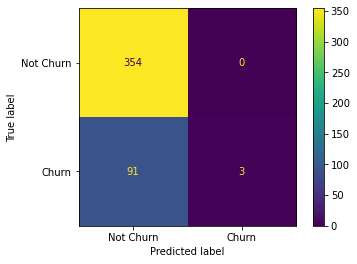

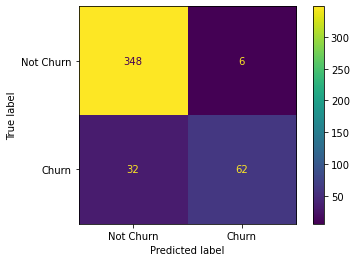

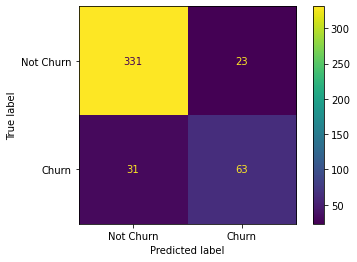

In [24]:
#Instantiating, fitting and evaluating LR, RF and DT models with random seed = 42

modeling(LogisticRegression, 'LR with Categories', Z_train_dum, Z_test_dum, y_train, y_test, results_dict, params = {'random_state': 42})

modeling(RandomForestClassifier, 'RF with Categories', Z_train_dum, Z_test_dum, y_train, y_test, results_dict, params = {'random_state': 42})

modeling(DecisionTreeClassifier, 'DT with Categories', Z_train_dum, Z_test_dum, y_train, y_test, results_dict, params = {'random_state': 42})

## What do these results mean? For Dummies:

The mild way to put this is that it was underwhelming. I have other choice words to use but... not the time or place. 

Anyway, it was as though nothing happened. For the Logistic Regression and Decision Tree Classifier, the test scores for all our evaluation metrics were exactly the same as previously. For the Random Forest Classifier, the metrics were slightly worse with the balanced accuracy dropping 2% and the recall dropping 3%. Consequently, I have decided against continuing with these dummies (no pun intended). Going forward we will stick with only the numerical columns. 

# Gradient Boosting (GB) model

,train_accuracy,test_accuracy,train_bal_accuracy,test_bal_accuracy,train_recall,test_recall,train_geom_mean,test_geom_mean,train_fbeta,test_fbeta
Logistic Regression,0.802871,0.796875,0.535152,0.515957,0.072727,0.031915,0.463372,0.432779,0.753723,0.741797
Random Forest,1.000000,0.924107,1.000000,0.838683,1.000000,0.691489,1.000000,0.834321,1.000000,0.920558
Decision Tree,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
LR with Categories,0.803828,0.796875,0.537424,0.515957,0.077273,0.031915,0.466748,0.432779,0.755267,0.741797
RF with Categories,1.000000,0.915179,1.000000,0.821313,1.000000,0.659574,1.000000,0.815931,1.000000,0.910886
DT with Categories,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
Gradient Boost,0.976077,0.915179,0.946515,0.821313,0.895455,0.659574,0.946053,0.815931,0.975661,0.910886


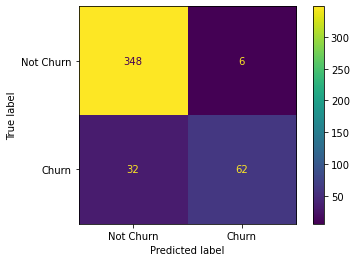

In [25]:
#Instantiating, fitting and evaluating a Gradient Boost model with random seed = 4

modeling(GradientBoostingClassifier, 'Gradient Boost', Z_train, Z_test, y_train, y_test, results_dict, params = {'random_state': 4})

## What does this result mean? GB Edition:

In terms of absolute performance, this wasn't our best. That accolade still belongs to the Random Forest model. However, this gradient boost model is slightly less overfit than the RF model. However, on recall, which is important to us, it performs worse than both the RF and DT models. And this is evident in the fact that it wrongly classifies 32 churned customers as not churn - compared to 29 and 31 for the RF and DT models respectively. 

# XGBoost Model

,train_accuracy,test_accuracy,train_bal_accuracy,test_bal_accuracy,train_recall,test_recall,train_geom_mean,test_geom_mean,train_fbeta,test_fbeta
Logistic Regression,0.802871,0.796875,0.535152,0.515957,0.072727,0.031915,0.463372,0.432779,0.753723,0.741797
Random Forest,1.000000,0.924107,1.000000,0.838683,1.000000,0.691489,1.000000,0.834321,1.000000,0.920558
Decision Tree,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
LR with Categories,0.803828,0.796875,0.537424,0.515957,0.077273,0.031915,0.466748,0.432779,0.755267,0.741797
RF with Categories,1.000000,0.915179,1.000000,0.821313,1.000000,0.659574,1.000000,0.815931,1.000000,0.910886
DT with Categories,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
Gradient Boost,0.976077,0.915179,0.946515,0.821313,0.895455,0.659574,0.946053,0.815931,0.975661,0.910886
XGBoost,1.000000,0.926339,1.000000,0.847908,1.000000,0.712766,1.000000,0.844273,1.000000,0.923454


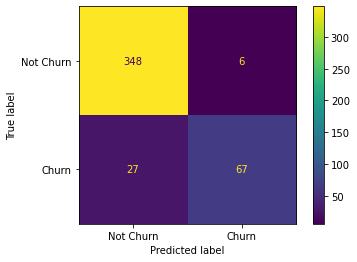

In [26]:
modeling(XGBClassifier, 'XGBoost', Z_train, Z_test, y_train, y_test, results_dict, params = {'random_state': 42})

## What does this result mean? XGBoost Edition: 

This is now our best model. On all metrics, it performs better, and its recall of 71.3% catches the eye as no other model had crossed 70% before now. 

It does a slightly better job of correctly predicting churned customers as churned. In 27 cases it got it wrong (compared to 29 by our previous best model).

# Bagging Classifier (BC) model

,train_accuracy,test_accuracy,train_bal_accuracy,test_bal_accuracy,train_recall,test_recall,train_geom_mean,test_geom_mean,train_fbeta,test_fbeta
Logistic Regression,0.802871,0.796875,0.535152,0.515957,0.072727,0.031915,0.463372,0.432779,0.753723,0.741797
Random Forest,1.000000,0.924107,1.000000,0.838683,1.000000,0.691489,1.000000,0.834321,1.000000,0.920558
Decision Tree,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
LR with Categories,0.803828,0.796875,0.537424,0.515957,0.077273,0.031915,0.466748,0.432779,0.755267,0.741797
RF with Categories,1.000000,0.915179,1.000000,0.821313,1.000000,0.659574,1.000000,0.815931,1.000000,0.910886
DT with Categories,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
Gradient Boost,0.976077,0.915179,0.946515,0.821313,0.895455,0.659574,0.946053,0.815931,0.975661,0.910886
XGBoost,1.000000,0.926339,1.000000,0.847908,1.000000,0.712766,1.000000,0.844273,1.000000,0.923454
Bagging Classifier,0.992344,0.924107,0.983485,0.842589,0.968182,0.702128,0.983445,0.838637,0.992309,0.920964


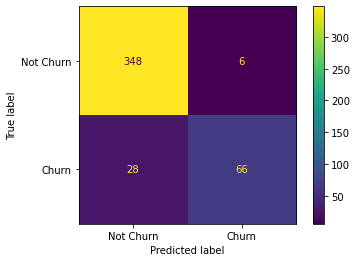

In [27]:
modeling(BaggingClassifier, 'Bagging Classifier', Z_train, Z_test, y_train, y_test, results_dict, params = {'random_state': 123})

## What does this result mean? Bagging Edition:
This is another good model. At 70% recall score, it is only slightly lower than our best model. It incorrectly predicts only 1 more churned customer compared to the best model so far. 

# Stacked Classifier

In [28]:
l1_estimator = [
    ('logr', LogisticRegression(random_state=123)),
    ('rf', RandomForestClassifier(random_state=123)),
    ('dt', DecisionTreeClassifier(random_state=123)),
    ('gb', GradientBoostingClassifier(random_state=123)),
    ('xgb', XGBClassifier(random_state=123)),
    ('bag', BaggingClassifier(base_estimator=RandomForestClassifier(random_state=123)))]

,train_accuracy,test_accuracy,train_bal_accuracy,test_bal_accuracy,train_recall,test_recall,train_geom_mean,test_geom_mean,train_fbeta,test_fbeta
Logistic Regression,0.802871,0.796875,0.535152,0.515957,0.072727,0.031915,0.463372,0.432779,0.753723,0.741797
Random Forest,1.000000,0.924107,1.000000,0.838683,1.000000,0.691489,1.000000,0.834321,1.000000,0.920558
Decision Tree,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
LR with Categories,0.803828,0.796875,0.537424,0.515957,0.077273,0.031915,0.466748,0.432779,0.755267,0.741797
RF with Categories,1.000000,0.915179,1.000000,0.821313,1.000000,0.659574,1.000000,0.815931,1.000000,0.910886
DT with Categories,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
Gradient Boost,0.976077,0.915179,0.946515,0.821313,0.895455,0.659574,0.946053,0.815931,0.975661,0.910886
XGBoost,1.000000,0.926339,1.000000,0.847908,1.000000,0.712766,1.000000,0.844273,1.000000,0.923454
Bagging Classifier,0.992344,0.924107,0.983485,0.842589,0.968182,0.702128,0.983445,0.838637,0.992309,0.920964
Stacked Classifier,0.969378,0.926339,0.972273,0.847908,0.977273,0.712766,0.972268,0.844273,0.969554,0.923454


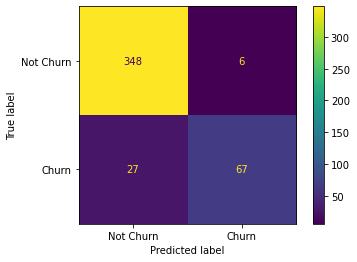

In [29]:
modeling(StackingClassifier, 'Stacked Classifier', Z_train, Z_test, y_train, y_test, results_dict, params = {'estimators': l1_estimator,
                              'final_estimator':XGBClassifier(random_state=123)})

# What does this mean? The Stacked Edition:

This is performing just as well as our top model. They have same scores on the test data, but this is slightly less overfit. They also got the exact same number in every quadrant of the confusion matrix. I think we have had enough of these base modeling. Now, let's select our top models and perform some hyperparameter tuning to see if we can improve performance. 

The top 4 models in no order are:
- Random Forest
- Bagging
- XGBoost
- Stacked

# Hyper-parameter tuning of our top models

## Random Forest encore

In [30]:
#Setting up a pipeline

rf_pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=123))
])

In [31]:
#USing a grid search to tune hyperparameters

rf_pipe_params = {
    'rf__n_estimators' : [100, 150, 200],
    'rf__max_depth': [3, 5, 7],
    'rf__min_samples_leaf': [10, 5, 7],
    'rf__max_features': ['auto', 0.2, 0.3, 'log2'],
    'rf__min_samples_split': [30, 40, 20]
}
    
rf_grid = GridSearchCV(rf_pipe, rf_pipe_params, cv=5, n_jobs=-1)

In [32]:
#fit rf_grid on the training data
rf_model = rf_grid.fit(Z_train, y_train)

#make predictions
rf_pred_test = rf_grid.predict(Z_test)

rf_pred_train = rf_grid.predict(Z_train) #doing this for comparison sake

In [33]:
#Defining a function to help with evaluation. Adapted from previous `modeling()` function in this notebook.

def evaluate (model, alg_name, X_train, X_test, y_train, y_test, preds_train, preds, results_dict):
    '''
    This function takes in the following inputs:
    - model = the name of your already fitted model
    - alg_name = The name you'll like the model to be called in output
    - X_train = a pandas dataframe containing the training data with your predictor features
    - X_test = a pandas dataframe containing the testing data with your predictor features
    - y_train = a pandas series containing your target feature in the train dataset
    - y_test = a pandas series containing your target feature in the test dataset
    - results_dict = a dictionary containing the ten evaluation metrics (five each for train and test sets) 
    from all previous models plus the ten evaluation metrics from the current model. 
    - preds_train = the predictions for your train set after `model.predict(X_train)`
    - preds_test = the predictions for your test set after `model.predict(X_test)`
    
    This function outputs the following:
    - results_df = a dataframe containing the items in the results_dict. 
    - A confusion matrix for the particular model being considered. 
    
    '''
    
    results_dict[alg_name] = {
    'train_accuracy' : model.score(X_train, y_train),
    'test_accuracy' : model.score(X_test, y_test), 
    'train_bal_accuracy' : balanced_accuracy_score(y_train, preds_train),
    'test_bal_accuracy' : balanced_accuracy_score(y_test, preds),
    'train_recall' : recall_score(y_train, preds_train),
    'test_recall' : recall_score(y_test, preds),
    'train_geom_mean' : geometric_mean_score(y_train, preds_train, average='weighted'),
    'test_geom_mean' : geometric_mean_score(y_test, preds, average='weighted'),
    'train_fbeta': fbeta_score(y_train, preds_train, average='weighted', beta=1.5),
    'test_fbeta': fbeta_score(y_test, preds, average='weighted', beta=1.5)
                }
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Not Churn', 'Churn'])
    
    #Then the results
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')

    
    return results_df

,train_accuracy,test_accuracy,train_bal_accuracy,test_bal_accuracy,train_recall,test_recall,train_geom_mean,test_geom_mean,train_fbeta,test_fbeta
Logistic Regression,0.802871,0.796875,0.535152,0.515957,0.072727,0.031915,0.463372,0.432779,0.753723,0.741797
Random Forest,1.000000,0.924107,1.000000,0.838683,1.000000,0.691489,1.000000,0.834321,1.000000,0.920558
Decision Tree,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
LR with Categories,0.803828,0.796875,0.537424,0.515957,0.077273,0.031915,0.466748,0.432779,0.755267,0.741797
RF with Categories,1.000000,0.915179,1.000000,0.821313,1.000000,0.659574,1.000000,0.815931,1.000000,0.910886
DT with Categories,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
Gradient Boost,0.976077,0.915179,0.946515,0.821313,0.895455,0.659574,0.946053,0.815931,0.975661,0.910886
XGBoost,1.000000,0.926339,1.000000,0.847908,1.000000,0.712766,1.000000,0.844273,1.000000,0.923454
Bagging Classifier,0.992344,0.924107,0.983485,0.842589,0.968182,0.702128,0.983445,0.838637,0.992309,0.920964
Stacked Classifier,0.969378,0.926339,0.972273,0.847908,0.977273,0.712766,0.972268,0.844273,0.969554,0.923454


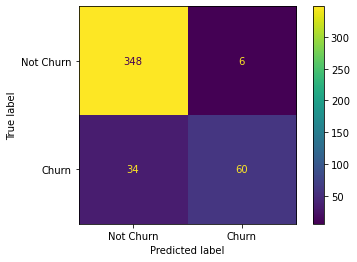

In [34]:
#Evaluating the random forest encore model
evaluate (rf_model, 'RF Encore', Z_train, Z_test, y_train, y_test, rf_pred_train, rf_pred_test, results_dict)

My hyper parameter tuning efforts did not yield much with random forest. It did not perform better than the previous model.

## Bagging Classifier encore

In [38]:
#Setting up pipeline

bag_pipe = Pipeline([
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=123)))
])

#Using a grid search to tune hyperparameters

bag_pipe_params = {
    'bag__base_estimator__max_depth': [15, 17, 20],
    'bag__base_estimator__min_samples_leaf': [12, 13, 11],
    'bag__base_estimator__max_features': [0.5, 0.9, 0.7],
    'bag__base_estimator__min_samples_split': [18, 16, 14]
}
    
bag_grid = GridSearchCV(bag_pipe, bag_pipe_params, cv=5, n_jobs=-1)

In [39]:
#fit bag_grid on the training data
bag_model = bag_grid.fit(Z_train, y_train)

#make predictions
bag_pred_test = bag_grid.predict(Z_test)

bag_pred_train = bag_grid.predict(Z_train)

,train_accuracy,test_accuracy,train_bal_accuracy,test_bal_accuracy,train_recall,test_recall,train_geom_mean,test_geom_mean,train_fbeta,test_fbeta
Logistic Regression,0.802871,0.796875,0.535152,0.515957,0.072727,0.031915,0.463372,0.432779,0.753723,0.741797
Random Forest,1.000000,0.924107,1.000000,0.838683,1.000000,0.691489,1.000000,0.834321,1.000000,0.920558
Decision Tree,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
LR with Categories,0.803828,0.796875,0.537424,0.515957,0.077273,0.031915,0.466748,0.432779,0.755267,0.741797
RF with Categories,1.000000,0.915179,1.000000,0.821313,1.000000,0.659574,1.000000,0.815931,1.000000,0.910886
DT with Categories,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
Gradient Boost,0.976077,0.915179,0.946515,0.821313,0.895455,0.659574,0.946053,0.815931,0.975661,0.910886
XGBoost,1.000000,0.926339,1.000000,0.847908,1.000000,0.712766,1.000000,0.844273,1.000000,0.923454
Bagging Classifier,0.992344,0.924107,0.983485,0.842589,0.968182,0.702128,0.983445,0.838637,0.992309,0.920964
Stacked Classifier,0.969378,0.926339,0.972273,0.847908,0.977273,0.712766,0.972268,0.844273,0.969554,0.923454


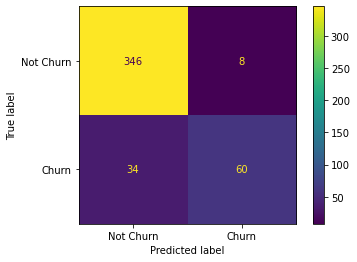

In [40]:
evaluate (bag_model, 'Bagging Encore', Z_train, Z_test, y_train, y_test, bag_pred_train, bag_pred_test, results_dict)

Again this did not work out for me.

## XGBoost encore

In [41]:
xgb_pipe = Pipeline([
    ('xgb', XGBClassifier(random_state=42))
])

xgb_pipe_params = {
    'xgb__n_estimators' : [100],
    'xgb__max_depth': [3, 4],
    'xgb__learning_rate': [.2, .3]
}

xgb_grid = GridSearchCV(xgb_pipe, xgb_pipe_params, cv=5)

In [42]:
#fit xgb_grid on the training data
xgb_model = xgb_grid.fit(Z_train, y_train)

#make predictions
xgb_pred_test = xgb_grid.predict(Z_test)

xgb_pred_train = xgb_grid.predict(Z_train)

,train_accuracy,test_accuracy,train_bal_accuracy,test_bal_accuracy,train_recall,test_recall,train_geom_mean,test_geom_mean,train_fbeta,test_fbeta
Logistic Regression,0.802871,0.796875,0.535152,0.515957,0.072727,0.031915,0.463372,0.432779,0.753723,0.741797
Random Forest,1.000000,0.924107,1.000000,0.838683,1.000000,0.691489,1.000000,0.834321,1.000000,0.920558
Decision Tree,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
LR with Categories,0.803828,0.796875,0.537424,0.515957,0.077273,0.031915,0.466748,0.432779,0.755267,0.741797
RF with Categories,1.000000,0.915179,1.000000,0.821313,1.000000,0.659574,1.000000,0.815931,1.000000,0.910886
DT with Categories,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
Gradient Boost,0.976077,0.915179,0.946515,0.821313,0.895455,0.659574,0.946053,0.815931,0.975661,0.910886
XGBoost,1.000000,0.926339,1.000000,0.847908,1.000000,0.712766,1.000000,0.844273,1.000000,0.923454
Bagging Classifier,0.992344,0.924107,0.983485,0.842589,0.968182,0.702128,0.983445,0.838637,0.992309,0.920964
Stacked Classifier,0.969378,0.926339,0.972273,0.847908,0.977273,0.712766,0.972268,0.844273,0.969554,0.923454


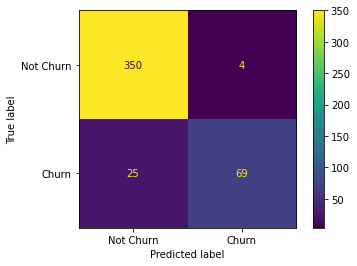

In [43]:
evaluate (xgb_model, 'XGBoost Encore', Z_train, Z_test, y_train, y_test, xgb_pred_train, xgb_pred_test, results_dict)

There is an improvement with this XGBoost model after tuning hyperparameters. The balanced accuracy is at an unprecedented 86%, the recall is at an unprecedentd 73%, the geometric mean is at an unprecedented 86%, and the fbeta score is at an unprecedented 93%. All the metrics we wanted to maximize are at their best scores. Even the traditional accuracy is at 94% - also, the highest. In the third quadrant, it is only wrongly classifying 25 churned as nont churned - the lowest so far. Furthermore, even though this is still overfit, it is not as overfit as the other models. We have time to try one last model.

## Stacked Model encore
No need to gridsearch here. We'll simply use the best estimators from our previous three models. 

In [51]:
level1_estimators = [('rf', rf_model.best_estimator_),
                     ('xgb', xgb_model.best_estimator_),
                    ('bag', bag_model.best_estimator_)]


stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator=XGBClassifier(random_state=4))

In [52]:
#fit xgb_grid on the training data
stacked = stacked_model.fit(Z_train, y_train)

#make predictions
stacked_pred_test = stacked_model.predict(Z_test)

stacked_pred_train = stacked_model.predict(Z_train)

,train_accuracy,test_accuracy,train_bal_accuracy,test_bal_accuracy,train_recall,test_recall,train_geom_mean,test_geom_mean,train_fbeta,test_fbeta
Logistic Regression,0.802871,0.796875,0.535152,0.515957,0.072727,0.031915,0.463372,0.432779,0.753723,0.741797
Random Forest,1.000000,0.924107,1.000000,0.838683,1.000000,0.691489,1.000000,0.834321,1.000000,0.920558
Decision Tree,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
LR with Categories,0.803828,0.796875,0.537424,0.515957,0.077273,0.031915,0.466748,0.432779,0.755267,0.741797
RF with Categories,1.000000,0.915179,1.000000,0.821313,1.000000,0.659574,1.000000,0.815931,1.000000,0.910886
DT with Categories,1.000000,0.879464,1.000000,0.802621,1.000000,0.670213,1.000000,0.798933,1.000000,0.878144
Gradient Boost,0.976077,0.915179,0.946515,0.821313,0.895455,0.659574,0.946053,0.815931,0.975661,0.910886
XGBoost,1.000000,0.926339,1.000000,0.847908,1.000000,0.712766,1.000000,0.844273,1.000000,0.923454
Bagging Classifier,0.992344,0.924107,0.983485,0.842589,0.968182,0.702128,0.983445,0.838637,0.992309,0.920964
Stacked Classifier,0.969378,0.926339,0.972273,0.847908,0.977273,0.712766,0.972268,0.844273,0.969554,0.923454


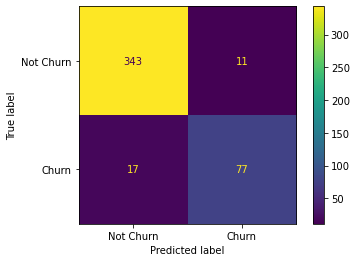

In [53]:
evaluate (stacked, 'Stacked Encore', Z_train, Z_test, y_train, y_test, stacked_pred_train, stacked_pred_test, results_dict)

# What does this mean? THE PRODUCTION MODEL EDITION:

By stacking the best estimators of some of our other models, we have managed to vastly improve the performance of our model. 
Consider the metrics of this stacked model:
- A balanced accuracy of 89% -- this is 3% more than the previous best balanced accuracy. It indicates that the model is performing just as well for both classes.
- A recall of 82% -- this is 9% more than the previous best recall score. It indicated that our model is doing better at minimizing false negatives which is exactly what we need. 
- An accuracy of 94% -- even though this was not our priority in this project, it is useful to observe that our model is 15% more accurate than the null model. Despite the inbalanced nature of the classes, this is massive. 
- A geometric mean of 89% -- recall that the geometric mean is a measure of the balance in the classification performances in both the positive and negative classes, which means that it is low if the model is doing great in predicting the majority class but not the minority one.
- Crucially, consider the third quadrant of the confusion matrix. This model is only incorrectly classifying 17 churned customers as not churned. That figure for the next closest model was 25. 

For all of these reasons, the stacked model would be our **PRODUCTION MODEL**

In [54]:
#Save the model
with open('../models/stacked_production_model.pkl', 'wb') as f:
    pickle.dump(stacked, f)

In [55]:
#Did it save?
with open('../models/stacked_production_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [56]:
model.score(Z_test, y_test)

0.9375